In [38]:
import pandas as pd
import numpy as np
import sys
import keras
import sklearn
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding
from keras.layers import LSTM, SimpleRNN, GRU, Bidirectional, BatchNormalization,Convolution1D,MaxPooling1D, Reshape, GlobalAveragePooling1D
from keras.utils import to_categorical
import sklearn.preprocessing
from sklearn import metrics
from scipy.stats import zscore
from tensorflow.keras.utils import get_file, plot_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
print(pd.__version__)
print(np.__version__)
print(sys.version)
print(sklearn.__version__)

1.2.4
1.23.3
3.10.8 (v3.10.8:aaaf517424, Oct 11 2022, 10:14:40) [Clang 13.0.0 (clang-1300.0.29.30)]
1.1.1


In [39]:
df = pd.read_table("./archive/KDDTrain+.txt", delimiter=",",header=None)

df.head()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [40]:
qp = pd.read_csv('./archive/KDDTest+.txt', header=None)
qp.head()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0,tcp,private,REJ,0,0,0,0,0,0,...,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21
1,0,tcp,private,REJ,0,0,0,0,0,0,...,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,normal,21
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,saint,15
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,mscan,11


In [41]:
#Reset column names for training set
df.columns = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
'num_access_files', 'num_outbound_cmds', 'is_host_login',
'is_guest_login', 'count', 'srv_count', 'serror_rate',
'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
'dst_host_srv_count', 'dst_host_same_srv_rate','dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
'dst_host_srv_rerror_rate', 'subclass', 'difficulty_level']
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,subclass,difficulty_level
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [42]:
#Reset column names for testing set
qp.columns = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
'num_access_files', 'num_outbound_cmds', 'is_host_login',
'is_guest_login', 'count', 'srv_count', 'serror_rate',
'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
'dst_host_srv_count', 'dst_host_same_srv_rate','dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
'dst_host_srv_rerror_rate', 'subclass', 'difficulty_level']
qp.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,subclass,difficulty_level
0,0,tcp,private,REJ,0,0,0,0,0,0,...,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21
1,0,tcp,private,REJ,0,0,0,0,0,0,...,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,normal,21
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,saint,15
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,mscan,11


In [43]:
#accessing names of training columns
lst_names = df.columns # returns a list of column names
lst_names

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'subclass', 'difficulty_level'],
      dtype='object')

In [44]:
#accessing names of testing columns
testlst_names = qp.columns
testlst_names

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'subclass', 'difficulty_level'],
      dtype='object')

In [45]:
#Dropping the last columns of training set
df = df.drop('difficulty_level', 1) # we don't need it in this project
df.shape

(125973, 42)

In [46]:
#Dropping the last columns of testing set
qp = qp.drop('difficulty_level', 1)
qp.shape

(22544, 42)

In [47]:
df.isnull().values.any()

False

In [48]:
qp.isnull().values.any()

False

In [49]:
#defining col list
cols = ['protocol_type','service','flag']
cols

['protocol_type', 'service', 'flag']

In [50]:
#One-hot encoding
def one_hot(df, cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode
    @return a DataFrame with one-hot encoding
    """
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(each, 1)
    return df

In [51]:
#Merging train and test data
combined_data = pd.concat([df,qp])

In [52]:
#Applying one hot encoding to combined data
combined_data = one_hot(combined_data,cols)

In [53]:
#Function to min-max normalize
def normalize(df, cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode
    @return a DataFrame with normalized specified features
    """
    result = df.copy() # do not touch the original df
    for feature_name in cols:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        if max_value > min_value:
            result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [54]:
#Dropping subclass column for training set
tmp = combined_data.pop('subclass')

In [55]:
tmp

0         normal
1         normal
2        neptune
3         normal
4         normal
          ...   
22539     normal
22540     normal
22541       back
22542     normal
22543      mscan
Name: subclass, Length: 148517, dtype: object

In [56]:
#Normalizing training set
new_train_df = normalize(combined_data,combined_data.columns)
new_train_df

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0.0,3.558064e-07,0.000000e+00,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.057999e-07,0.000000e+00,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.681203e-07,6.223962e-06,0.0,0.0,0.0,0.000000,0.0,1.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.442067e-07,3.206260e-07,0.0,0.0,0.0,0.000000,0.0,1.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22539,0.0,5.753774e-07,2.542106e-07,0.0,0.0,0.0,0.000000,0.0,1.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
22540,0.0,2.297162e-07,7.160648e-07,0.0,0.0,0.0,0.000000,0.0,1.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
22541,0.0,3.952277e-05,6.346868e-06,0.0,0.0,0.0,0.019802,0.0,1.0,0.000134,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
22542,0.0,3.043558e-08,3.206260e-08,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [57]:
#Fixing labels for training set
classlist = []
check1 = ("apache2","back","land","neptune","mailbomb","pod","processtable","smurf","teardrop","udpstorm","worm")
check2 = ("ipsweep","mscan","nmap","portsweep","saint","satan")
check3 = ("buffer_overflow","loadmodule","perl","ps","rootkit","sqlattack","xterm")
check4 = ("ftp_write","guess_passwd","httptunnel","imap","multihop","named","phf","sendmail","Snmpgetattack","spy","snmpguess","warezclient","warezmaster","xlock","xsnoop")

DoSCount=0
ProbeCount=0
U2RCount=0
R2LCount=0
NormalCount=0

for item in tmp:
    if item in check1:
        classlist.append("DOS")
        DoSCount=DoSCount+1
    elif item in check2:
        classlist.append("Probe")
        ProbeCount=ProbeCount+1
    elif item in check3:
        classlist.append("U2R")
        U2RCount=U2RCount+1
    elif item in check4:
        classlist.append("R2L")
        R2LCount=R2LCount+1
    else:
        classlist.append("Normal")
        NormalCount=NormalCount+1   

In [58]:
classlist

['Normal',
 'Normal',
 'DOS',
 'Normal',
 'Normal',
 'DOS',
 'DOS',
 'DOS',
 'DOS',
 'DOS',
 'DOS',
 'DOS',
 'Normal',
 'R2L',
 'DOS',
 'DOS',
 'Normal',
 'Probe',
 'Normal',
 'Normal',
 'DOS',
 'DOS',
 'Normal',
 'Normal',
 'DOS',
 'Normal',
 'DOS',
 'Normal',
 'Normal',
 'Normal',
 'Probe',
 'DOS',
 'Normal',
 'Probe',
 'Normal',
 'Normal',
 'Normal',
 'DOS',
 'Normal',
 'DOS',
 'DOS',
 'DOS',
 'Normal',
 'Normal',
 'Normal',
 'DOS',
 'DOS',
 'Normal',
 'R2L',
 'DOS',
 'Normal',
 'DOS',
 'DOS',
 'Normal',
 'Normal',
 'Normal',
 'Probe',
 'DOS',
 'DOS',
 'Normal',
 'Normal',
 'DOS',
 'Probe',
 'Normal',
 'DOS',
 'Normal',
 'Probe',
 'DOS',
 'DOS',
 'DOS',
 'Normal',
 'DOS',
 'Normal',
 'Normal',
 'DOS',
 'Normal',
 'DOS',
 'Normal',
 'Normal',
 'DOS',
 'Normal',
 'DOS',
 'DOS',
 'Probe',
 'Normal',
 'DOS',
 'Normal',
 'DOS',
 'DOS',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'DOS',
 'DOS',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'DOS',
 'Normal',
 'Normal',
 'Normal',
 'Normal'

In [59]:
#Appending class column to training set
new_train_df["Class"] = classlist
new_train_df

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,Class
0,0.0,3.558064e-07,0.000000e+00,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Normal
1,0.0,1.057999e-07,0.000000e+00,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Normal
2,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,DOS
3,0.0,1.681203e-07,6.223962e-06,0.0,0.0,0.0,0.000000,0.0,1.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Normal
4,0.0,1.442067e-07,3.206260e-07,0.0,0.0,0.0,0.000000,0.0,1.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22539,0.0,5.753774e-07,2.542106e-07,0.0,0.0,0.0,0.000000,0.0,1.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Normal
22540,0.0,2.297162e-07,7.160648e-07,0.0,0.0,0.0,0.000000,0.0,1.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Normal
22541,0.0,3.952277e-05,6.346868e-06,0.0,0.0,0.0,0.019802,0.0,1.0,0.000134,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,DOS
22542,0.0,3.043558e-08,3.206260e-08,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Normal


In [60]:
new_train_df["Class"].value_counts()

Normal    77232
DOS       53387
Probe     14077
R2L        3702
U2R         119
Name: Class, dtype: int64

In [61]:
new_train_df.isnull().values.any()

False

In [62]:
y_train=new_train_df["Class"]
y_train

0        Normal
1        Normal
2           DOS
3        Normal
4        Normal
          ...  
22539    Normal
22540    Normal
22541       DOS
22542    Normal
22543     Probe
Name: Class, Length: 148517, dtype: object

In [63]:
y_train.isnull().values.any()

False

In [64]:
combined_data_X = new_train_df.drop('Class', 1)
combined_data_X

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0.0,3.558064e-07,0.000000e+00,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.057999e-07,0.000000e+00,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.681203e-07,6.223962e-06,0.0,0.0,0.0,0.000000,0.0,1.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.442067e-07,3.206260e-07,0.0,0.0,0.0,0.000000,0.0,1.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22539,0.0,5.753774e-07,2.542106e-07,0.0,0.0,0.0,0.000000,0.0,1.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
22540,0.0,2.297162e-07,7.160648e-07,0.0,0.0,0.0,0.000000,0.0,1.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
22541,0.0,3.952277e-05,6.346868e-06,0.0,0.0,0.0,0.019802,0.0,1.0,0.000134,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
22542,0.0,3.043558e-08,3.206260e-08,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [65]:
oos_pred = []

In [66]:
from sklearn.model_selection import StratifiedKFold

In [67]:
kfold = StratifiedKFold(n_splits=10,shuffle=True,random_state=42)
kfold.get_n_splits(combined_data_X,y_train)

10

In [72]:
batch_size = 32
model = Sequential()
model.add(Convolution1D(64, kernel_size=122, padding="same",activation="relu",input_shape=(122, 1)))
model.add(MaxPooling1D(pool_size=(5)))
model.add(BatchNormalization())
model.add(Bidirectional(GRU(64, return_sequences=False))) 
model.add(Reshape((128, 1), input_shape = (128, )))

model.add(MaxPooling1D(pool_size=(5)))
model.add(BatchNormalization())
model.add(Bidirectional(GRU(128, return_sequences=False))) 

model.add(Dropout(0.5))
model.add(Dense(5))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [73]:
for layer in model.layers:
    print(layer.output_shape)

(None, 122, 64)
(None, 24, 64)
(None, 24, 64)
(None, 128)
(None, 128, 1)
(None, 25, 1)
(None, 25, 1)
(None, 256)
(None, 256)
(None, 5)
(None, 5)


In [74]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 122, 64)           7872      
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 24, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization_5 (Batc  (None, 24, 64)           256       
 hNormalization)                                                 
                                                                 
 bidirectional_5 (Bidirectio  (None, 128)              49920     
 nal)                                                            
                                                                 
 reshape_3 (Reshape)         (None, 128, 1)            0         
                                                      

In [75]:
for train_index, test_index in kfold.split(combined_data_X,y_train):
    train_X, test_X = combined_data_X.iloc[train_index], combined_data_X.iloc[test_index]
    train_y, test_y = y_train.iloc[train_index], y_train.iloc[test_index]
    
    print("train index:",train_index)
    print("test index:",test_index)
    
    x_columns_train = new_train_df.columns.drop('Class')
    x_train_array = train_X[x_columns_train].values
    x_train_1=np.reshape(x_train_array, (x_train_array.shape[0], x_train_array.shape[1], 1))
    
    dummies = pd.get_dummies(train_y) # Classification
    outcomes = dummies.columns
    num_classes = len(outcomes)
    y_train_1 = dummies.values
    
    x_columns_test = new_train_df.columns.drop('Class')
    x_test_array = test_X[x_columns_test].values
    x_test_2=np.reshape(x_test_array, (x_test_array.shape[0], x_test_array.shape[1], 1))
    
    dummies_test = pd.get_dummies(test_y) # Classification
    outcomes_test = dummies_test.columns
    num_classes = len(outcomes_test)
    y_test_2 = dummies_test.values
    
    model.fit(x_train_1, y_train_1,validation_data=(x_test_2,y_test_2), epochs=10)
    
    pred = model.predict(x_test_2)
    pred = np.argmax(pred,axis=1)
    y_eval = np.argmax(y_test_2,axis=1)
    score = metrics.accuracy_score(y_eval, pred)
    oos_pred.append(score)
    print("Validation score: {}".format(score))

train index: [     0      2      3 ... 148514 148515 148516]
test index: [     1      7     18 ... 148506 148511 148513]
Epoch 1/10
4178/4178 [==============================] - 132s 30ms/step - loss: 0.1026 - accuracy: 0.9666 - val_loss: 0.0686 - val_accuracy: 0.9774
Epoch 2/10
4178/4178 [==============================] - 127s 30ms/step - loss: 0.0565 - accuracy: 0.9805 - val_loss: 0.0405 - val_accuracy: 0.9859
Epoch 3/10
4178/4178 [==============================] - 126s 30ms/step - loss: 0.0469 - accuracy: 0.9837 - val_loss: 0.0478 - val_accuracy: 0.9841
Epoch 4/10
4178/4178 [==============================] - 125s 30ms/step - loss: 0.0423 - accuracy: 0.9854 - val_loss: 0.0485 - val_accuracy: 0.9844
Epoch 5/10
4178/4178 [==============================] - 123s 29ms/step - loss: 0.0387 - accuracy: 0.9867 - val_loss: 0.0362 - val_accuracy: 0.9882
Epoch 6/10
4178/4178 [==============================] - 123s 29ms/step - loss: 0.0357 - accuracy: 0.9881 - val_loss: 0.0324 - val_accuracy: 0.98

465/465 [==============================] - 4s 8ms/step
Validation score: 0.9933342310799892
train index: [     0      1      2 ... 148513 148515 148516]
test index: [     6     20     36 ... 148509 148510 148514]
Epoch 1/10
4178/4178 [==============================] - 134s 32ms/step - loss: 0.0192 - accuracy: 0.9931 - val_loss: 0.0182 - val_accuracy: 0.9935
Epoch 2/10
4178/4178 [==============================] - 145s 35ms/step - loss: 0.0192 - accuracy: 0.9930 - val_loss: 0.0158 - val_accuracy: 0.9941
Epoch 3/10
4178/4178 [==============================] - 138s 33ms/step - loss: 0.0191 - accuracy: 0.9931 - val_loss: 0.0216 - val_accuracy: 0.9937
Epoch 4/10
4178/4178 [==============================] - 137s 33ms/step - loss: 0.0187 - accuracy: 0.9933 - val_loss: 0.0182 - val_accuracy: 0.9935
Epoch 5/10
4178/4178 [==============================] - 136s 33ms/step - loss: 0.0182 - accuracy: 0.9934 - val_loss: 0.0270 - val_accuracy: 0.9922
Epoch 6/10
4178/4178 [==============================

4178/4178 [==============================] - 137s 33ms/step - loss: 0.0167 - accuracy: 0.9941 - val_loss: 0.0228 - val_accuracy: 0.9924
Epoch 9/10
4178/4178 [==============================] - 136s 32ms/step - loss: 0.0165 - accuracy: 0.9940 - val_loss: 0.0235 - val_accuracy: 0.9918
Epoch 10/10
465/465 [==============================] - 3s 7ms/step
Validation score: 0.9922564137095146


In [76]:
oos_pred

[0.9883517371397792,
 0.9890923781308915,
 0.9886210611365472,
 0.992997576084029,
 0.9932669000807972,
 0.9933342310799892,
 0.9941422030702936,
 0.9934688930783733,
 0.9925930913743183,
 0.9938724665005724,
 0.9922564137095146]

In [77]:
dummies_test.columns

Index(['DOS', 'Normal', 'Probe', 'R2L', 'U2R'], dtype='object')

In [79]:
from sklearn.metrics import confusion_matrix
confussion_matrix=confusion_matrix(y_eval, pred, labels=[0,1,2,3,4])
confussion_matrix

array([[5326,   12,    0,    0,    0],
       [   4, 7680,   13,   26,    0],
       [   1,   14, 1391,    0,    1],
       [   0,   34,    1,  335,    1],
       [   0,    5,    0,    3,    4]])

In [80]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

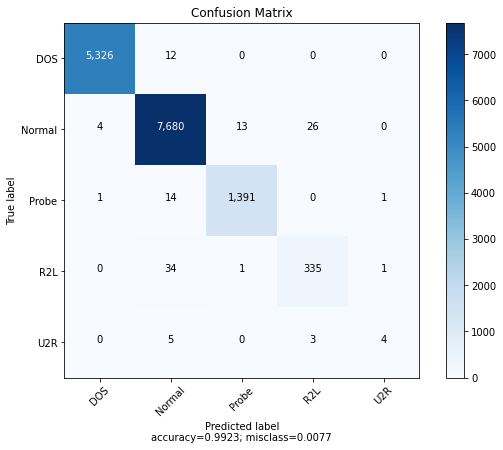

In [81]:
plot_confusion_matrix(cm           = confussion_matrix, 
                      normalize    = False,
                      target_names = ["DOS","Normal","Probe","R2L","U2R"],
                      title        = "Confusion Matrix")

465/465 [==============================] - 3s 6ms/step


/var/folders/sx/c0164zfd7tq1cpbq2klyn1400000gq/T/ipykernel_1363/1247927668.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


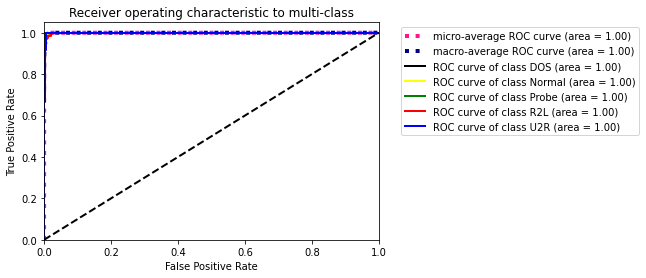

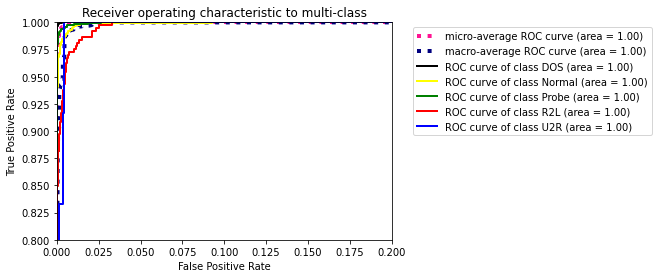

In [82]:
target_class=[]
target_class=["DOS","Normal","Probe","R2L","U2R"]

import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc

pred1 = model.predict(x_test_2)

# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_test_2[:, i], pred1[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_2.ravel(), pred1.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(5)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(5):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 5

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['black', 'yellow', 'green','red','blue'])
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(target_class[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

#zoom in the plot
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['black', 'yellow', 'green','red','blue'])
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(target_class[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()